# Challenge
The year is 2912. To commemorate the 1,000th anniversary of the tragic sinking of the RMS Titanic, RoboMech Space Industries (RMS) unveiled their latest marvel: an interstellar cruise liner honourably named the Titanic. This state-of-the-art vessel promised luxury and adventure across the stars. However, while rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Mirroring the fate of its namesake from a millennium ago, the ship stayed intact, but almost half of the passengers were transported to an alternate dimension. In the ensuing chaos, some data about these transported individuals was partially recovered, but much of it is incomplete. Amid this crisis, you have been hired for a crucial mission: to develop a machine learning algorithm capable of sifting through the remaining data to accurately identify which passengers were transported. Your expertise is vital in piecing together this digital puzzle and ensuring the safe return of those lost in the vast expanse of space.

# Your Task

Your client, RoboMech Space Industries, has hired you to develop a Machine Learning algorithm to predict whether or not someone aboard their interstellar cruiseliner was transported by the anomaly. They have provided you with all of the data they were able to recover, along with the passenger's "transported" status. You are expected to produce a detailed code notebook that showcases the data preparation and machine learning you perform, and demonstrate that you have constructed an adequately trained high performance model.

#**Libraries**
This cell imports all of the necessary libraries used for this assignment.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Installs umap for Google Colab.
try:
  from umap import UMAP
except ImportError:
  !pip install umap-learn
  from umap import UMAP

This cell mounts my google drive to the notebook in order to access the  spaceship-titanic.csv file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**My Solution**

My solution is broken into three key areas, being:

*   Classes to perform all of the data preparation and generate my three models, being, a Decision Tree, Random Forest, and Atrificial Neural Net.
*   Applying the classes to the provided data set spaceship-titanic.csv.
*   Final summary of the models, and their results with and without clustering.

The first section includes a text segment describing what each class does, its constituent functions, and the purpose of each function.
The functions also contain doc-strings which give more details on their arguments, as well as what they return where applicable.
For ease of understanding, the code is also commented according to each significant process.

The second section is then used to test the functionality of each class. This again is broken into two sections, testing each of the three models on data that has been cleaned and feature engineered both with, and without clustering techniques. This section also includes a more detailed look at the process used to imploy the classes, and hyperparameter tune each of the models.

The final section compares the accuracy of each of the models using feature engineering techniques both with and without clustering.

#**Data Cleaning and Fearure Engineering**
This cell is used for cleaning and feature engineering of the provided  spaceship-titanic.csv file. This is split into three key processes, being


*   Data cleaning
*   Feature engineering without clustering
*   Feature engineering with clustering

This is achieved by creating a class DataPreparation with 5 functions.

####**\__init__(self, data_frame):**

This function simply initialises the data frame in the class.

####**clean(self):**

This function is used to clen the data. This is achieved by:


*   Dropping the 'Names' feature, as this cannot be used in any usefule manner.
*   Dropping any rows with in the features 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', and 'VIP' with NaN values, as these cannot be imputed.
*   Imputing the missing values from the features 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', and 'VRDeck'. These are computed to be the average value of that feature from the persons corresponding 'HomePlanet'.
*   One-hot encoding the features 'HomePlanet' and 'Destination'. These are then assigned True or False values, which can now be interpreted by the computer.

####**Feature_Engineering(self, clustering):**

This function performs feature engineering with and without clustering. This is achieved by:

*   Numerically encoding the feature 'PassengerId' into two new features. Feature one being 'IdGroup' corresponding to the group number that person belonged to, and the feature 'IdGroupNum', corresponding to the number in that group that the person was assigned. I thought there could be some correlation between large groups and families, and group numbers possibly corresponding to whether that person was a child or specific parent, which the computer could then relate to 'transportability'.
*   Dropping the now unnecessary feature 'PassengerId'.
*   Numerically encoding the feature 'Cabin' into three features. The first being 'CabinDeck' corresponding to the deck that persons cabins was located on, 'CabinNum', corresponding to the cabins number, and 'CabinSide' corresponding to the side of the ship the cabin was located on. I thought there may be some correlation between proximity to the spacetime anomoly that the computer could again relate to 'transportability'.
*   Finally, One-hot encode the 'CabinDeck' and 'CabinSide' features so that they become True/False values that can be interpreted by the computer.
*   If clustering = True, this function will create a new feature 'UMAPCluster'.
*   To do this I first scale the data.
*   It then generates a 2 dimensional UMAP of the data using all current features.
*   It will then perform DBSCAN on the UMAP to identify clusters.
*   Finally it will create a new feature 'UMAPCluster' corresponding to the cluster label of each point.

####**plot_UMAP(self, target_var):**
This function will plot the UMAP generated for clustering in Feature_Engineering, with the points coloured according to the target variable.

####**plot_UMAP_clust(self):**
This function will plot the UMAP generated for clustering in Feature_Engineering, with the points coloured according to the cluster label identified by DBSCAN.




In [ ]:
class DataPreparation(object):
  """This class is used to clean the data, and perform Feature Engineering"""

  def __init__(self, data_frame):
    """
    Initialises the data frame.

    Args:
        data_frame (pandas.DataFrame): The data frame being used for
        Machine Learning

    Returns:
        None
    """
    self.df = data_frame

  def clean(self):
    """
    Cleans the data.

    Args:
        None

    Returns:
        None
    """
    # drop unnecessary column Name, as this cannot be used in any meaningful way
    self.df.drop('Name', axis=1, inplace=True)

    # drop any rows with nan values in 'HomePlanet', 'CryoSleep', 'Cabin',
    # 'Destination', and 'VIP' as these cannot be imputed
    self.df = self.df.loc[(self.df.isna().HomePlanet == False)
                & (self.df.isna().CryoSleep == False)
                & (self.df.isna().Cabin == False)
                & (self.df.isna().Destination == False)
                & (self.df.isna().VIP == False)]


    # Impute 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', and 'VRDeck' from average
    # value of corresponding 'HomePlanet'
    to_impute = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
    for col in to_impute:
      for planet in self.df['HomePlanet'].unique():
          mean = round(self.df[self.df['HomePlanet'] == planet][col].mean())
          self.df.loc[(self.df[col].isnull())
                        & (self.df['HomePlanet'] == planet), col] = mean

    # One-hot encode the 'HomePlanet' column
    self.df = pd.get_dummies(self.df, columns=['HomePlanet'])

    # One-hot encode the 'Destination' column
    self.df = pd.get_dummies(self.df, columns=['Destination'])

  def Feature_Engineer(self, clustering):
    """
    Performs Feature Engineering both with and without clustering.

    Args:
        clustering (bool): If False, will perfome Feature Engineering without
        clustering. If True, will perfome Feature Engineering with clustering.

    Returns:
        None
    """
    # Numerically encode PassengerId into two categroies, group (IdGroup), and group number (IdGroupNum)
    self.df['IdGroup'], self.df['IdGroupNum'] = \
                np.array([id.split('_') for id in self.df.PassengerId]).T
    self.df.IdGroup, self.df.IdGroupNum = \
                self.df.IdGroup.astype(int), self.df.IdGroupNum.astype(int)
    # drop the now unnecessary column PassengerId
    self.df.drop('PassengerId', axis=1, inplace=True)

    # Numerically encode Cabin into three categroies, deck (CabinDeck),
    # cabin number (CabinNum), and side of the ship (CabinSide)
    self.df['CabinDeck'], self.df['CabinNum'], self.df['CabinSide']  = \
                np.array([cabin.split('/') for cabin in self.df.Cabin]).T
    self.df.drop('Cabin', axis=1, inplace=True)

    # One-hot encode the 'CabinDeck' and 'CabinSide' columns
    self.df = pd.get_dummies(self.df, columns=['CabinDeck'])
    self.df = pd.get_dummies(self.df, columns=['CabinSide'])

    # Perform clustering if clustering=True
    if clustering:
      # Scale data to create UMAP
      scaler = StandardScaler()
      df_scaled = scaler.fit_transform(self.df)
      df_scaled = pd.DataFrame(df_scaled, columns = self.df.columns)

      # Create a 2 dimensional UMAP
      umap = UMAP(n_components=2, random_state=42)
      X_umap = umap.fit_transform(df_scaled)
      self.umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])

      # Perform DBScan on the UMAP and add a cluster feature to the data frame.
      dbscan = DBSCAN(eps=0.5, min_samples=20)
      clusters = dbscan.fit_predict(self.umap_df)
      self.umap_df['cluster_label'] = clusters
      self.df['UMAPCluster'] = clusters

  def plot_UMAP(self, target_var):
    """
    Generates a figure displaying the UMAP result, with points colored based
    on the target varaibles.

    Args:
        target_var (str): The target variable

    Returns:
        None
    """
    # Create UMAP and colour points according to target value.
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=self.umap_df, x='UMAP1', y='UMAP2', s=5,
                    hue=self.df[target_var], palette='bright')

  def plot_UMAP_clust(self):
    """
    Generates a figure displaying the UMAP result, with points colored based
    on clusters determined by a DBScan.

    Args:
        None

    Returns:
        None
    """
    # Create UMAP and color points according to cluster.
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=self.umap_df, x='UMAP1', y='UMAP2', s=10,
                    hue='cluster_label', palette='bright', legend=False)


#**Tree Based Learning**

This cell is used to generate a Decision Tree Classifier. This is achieved using the class StandardTree. This class conatins 4 functions, including:

####**\__init__(self, data_frame, target_var):**

This function is used to initialise the training features 'X', and target variable 'y', using the inputs 'data_frame' and 'target_var'.
It then splits these variables into train and test variables, with an 80-20 split respectively.

####**new_DTC(self, min_ssplit, min_sleaf, max_d):**

This function is used to generate a standard Decision Tree Classifier with the hyperparameters min_samples_split=min_ssplit, min_samples_leaf=min_sleaf, max_depth=max_d.
It then fits the decision tree to the training data.

####**accuracy(self):**
This function returns the accuracy of the tree prediciting the target variable. This is achieved using sklearns accuracy_score function.

####**show_tree(self):**
This function generates a figure displaying the current Decission Tree using the plot_tree function.

In [ ]:
class StandardTree(object):
  """
  This Class is used to generate a standard Decision Tree Classifier
  """

  def __init__(self, data_frame, target_var):
    """
    Splits the data frame into learning features 'X' and the target variable 'y'
    and fits a standard Decision Tree Classifier to the training sets.

    Args:
        data_frame (pandas.DataFrame): data frame to be used for machine learning
        target_var (str): String defining the target variable of the data frame

    Returns:
        None
    """
    self.X = data_frame.drop(columns=target_var)    # Isolate desired features for Learning
    self.y = data_frame[target_var]                 # Isolate target variable

    # Separate Features and target variable into Training and Test sets
    self.X_train, self.X_test, self.y_train, self.y_test = \
              train_test_split(self.X, self.y, test_size=0.2, random_state=42)


  # Function to optionally update decisison tree Hyperparameters from standard values
  def new_DTC(self, min_ssplit, min_sleaf, max_d):
    """
    Creates a new decision tree with the provided hyperparameters, then fits
    it to the training data.

    Args:
        min_ssplit (int): Minimum samples required to perform a leaf split
        min_sleaf (int): Minimum samples required to form a leaf
        max_d (int): Maximum depth that the tree can reach

    Returns:
        None
    """
    self.dt = DecisionTreeClassifier(min_samples_split=min_ssplit,
                                     min_samples_leaf=min_sleaf,
                                     max_depth=max_d, random_state=42)
    self.dt.fit(self.X_train, self.y_train)

  # Function to return the accuracy of the decision tree
  def accuracy(self):
    """
    Returns the accuracy of the tree prediciting the target variable.

    Args:
        None

    Returns:
        accuracy_score (float): The fraction of correctly classified samples
    """
    y_pred = self.dt.predict(self.X_test)
    return accuracy_score(self.y_test, y_pred)

  # Function to visualise the decisison tree
  def show_tree(self):
    """
    Produces a figure displaying the current Decision Tree.

    Args:
        None

    Returns:
        None
    """
    plt.figure(figsize=[10,10])
    plot_tree(self.dt, filled=True, feature_names=self.X.columns,
              fontsize=6, rounded=True)
    plt.show()


#**Random Forest Based Learning**

This cell is used to generate a Random Forest. This is achieved using the class RandomForest. This class conatins 4 functions, including:

####**\__init__(self, data_frame, target_var):**
This function is used to initialise the training features 'X', and target variable 'y', using the inputs 'data_frame' and 'target_var'.
It then splits these variables into train and test variables, with an 80-20 split respectively.
It then generates a standard standard Random Forest Classifier without any provided hyperparameters.

####**grid_search(self, param_grid):**

This function performs a cross validation grid search on the provided parameter grid (param_grid) using GridSearchCV for the current random forrest model. This will compare and find the best Hyperparamaters for the model from the provided options in in the library param_grid.
This function will then finally update the best hyperparameters for the Random Forest model.

####**new_RFC(self):**

This function is used to generate a new Random Forest with the best hyperparameters found using the grid_search function. It will then update the current model, and fit it to the training data.

####**accuracy(self):**

This function returns the accuracy of the model predicting the target variable using sklearns accuracy_score. It also returns the predicted values y_pred, which can be used to create a confusion matrix.

In [ ]:
class RandomForest(object):
  """
  This Class is used to generate a standard Decision Tree Classifier
  """

  def __init__(self, data_frame, target_var):
    """
    Splits the data frame into learning features 'X' and the target variable 'y'
    and creates a Randome Rorrest Classifier.

    Args:
        data_frame (pandas.DataFrame): data frame to be used for machine learning
        target_var (str): String defining the target variable of the data frame

    Returns:
        None
    """
    self.X = data_frame.drop(columns=target_var)     # Isolate desired features for Learning
    self.y = data_frame[target_var]                  # Isolate target variable

    # Separate Features and target variable into Training and Test sets
    self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.y, test_size=0.2, random_state=42)

    self.rf_model = RandomForestClassifier(random_state=42)

  # Perform a grid search on a new param_grid
  def grid_search(self, param_grid):
    """
    Takes a grid of Hyperparameters and performs a grid search to find which
    parameters give the best fitting model.

    Args:
        param_grid (dict): A dictionary containing the Hyperparameters
        n_estimators, max_depth, min_samples_split, min_samples_leaf and a
        list of possible integers for each param.

    Returns:
        Prints the best parameters found, and the assosciated best score.

    """
    grid_search = GridSearchCV(estimator=self.rf_model,
                               param_grid=param_grid, cv=3)
    grid_search.fit(self.X_train, self.y_train)

    print("Best parameters found:", grid_search.best_params_)
    print("Best score found: ", grid_search.best_score_)
    self.best_params = grid_search.best_params_

  # Create Random Forest Classifier for best fit parameters
  def new_RFC(self):
    """
    This functions generates a new Random Forest Classifier for the best
    parameters found from the previous grid search

    Args:
        None
    Returns:
        None
    """
    self.rf_model = RandomForestClassifier(**self.best_params, random_state=42)
    self.rf_model.fit(self.X_train, self.y_train)

  # Return the accuracy of the current model.
  def accuracy(self):
    """
    Returns the accuracy of the RFC prediciting the target variable.

    Args:
        None

    Returns:
        accuracy_score (float): The fraction of correctly classified samples
    """
    self.y_pred = self.rf_model.predict(self.X_test)
    return accuracy_score(self.y_test, self.y_pred)


#**ANN Based Learning**
This cell is used to generate an Artificial Neural Network. This is achieved using the class ANN. This class conatins 6 functions, including:

####**\__init__(self, data_frame, target_var):**
This function is used to initialise the training features 'X', and target variable 'y', using the inputs 'data_frame' and 'target_var'.
It then splits these variables into training, test, and valiadation variables, with a 70-15-15 split respectively.
It then balances the training sets by sampling random values from each with replacement (i.e a point can be picked twice).
It then scales all of the learning features (X train/validation/test) between 0 and 1, which is required for an Artificial Neural Net to accurately backpropogate weights.

####**model(self, Model):**

This function takes as input a list, called Model. This list should contain the desired number of layers for the ANN, typically being Dense layers. Each layer should have a specified number of neurons, activations function (typically relu), and a shape.

####**optimizer(self, eta):**

This creates an optimiser function using ADAM with the learning rate specified by eta.

####**train(self, loss_func, batch_size, epochs):**

This trains the ANN on the training and validation data using the hyperparameters loss_func to specifiy the desired loss function, number of epochs - to specify the number of iterations the training set should pass through the ANN - and batch_size - to specify how many batches to split the data into to perform a batch gradient decent.
We perform batch gradient decent in order to avoid overfitting, by having the ANN's weights converge before all of the training data has been seen by the model.

####**loss_curve(self):**

This function produces a figure plotting the loss curves of both the training and validation data. This can be used to ensure we don't run into issues such as over/underfitting.

####**accuracy(self):**
This function returns the accuracy of the model predicting the target variable using sklearns accuracy_score.

In [ ]:
class ANN(object):
  """This class is used to generate an Atrificial Neural Network"""

  def __init__(self, data_frame, target_var):
    """
    Splits the data frame into learning features 'X' and the target variable 'y'
    creates scaled and balanced arrays of the training, validation and test
    data sets.

    Args:
        data_frame (pandas.DataFrame): data frame to be used for machine learning
        target_var (str): String defining the target variable of the data frame

    Returns:
        None
    """
    self.X = data_frame.drop(columns=target_var)       # Isolate desired features for Learning
    self.y = data_frame[target_var]                    # Isolate target variable

    # Separate Features and target variable into Training and Test sets
    X_train, X_temp, y_train, y_temp = \
            train_test_split(self.X, self.y, test_size=0.3, random_state=42)
    X_val, X_test, self.y_val, self.y_test = \
            train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Balance the samples from each data set
    X_train_0 = X_train[y_train==0].sample(1000, random_state=42, replace=True)
    X_train_1 = X_train[y_train==1].sample(1000, random_state=42, replace=True)
    y_train_0 = y_train[y_train==0].sample(1000, random_state=42, replace=True)
    y_train_1 = y_train[y_train==1].sample(1000, random_state=42, replace=True)

    X_balanced = pd.concat([X_train_0, X_train_1])
    self.y_balanced = pd.concat([y_train_0, y_train_1])

    # Scale the data between 0 - 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scl= scaler.fit_transform(X_balanced)
    X_val_scl = scaler.fit_transform(X_val)
    X_test_scl = scaler.fit_transform(X_test)

    self.X_train = pd.DataFrame(X_scl, columns = X_balanced.columns)
    self.X_val  = pd.DataFrame(X_val_scl, columns = X_val.columns)
    self.X_test = pd.DataFrame(X_test_scl, columns = X_test.columns)

  # Generate the required sequential model.
  def model(self, Model):
    """
    Creates an sequential ANN model with the provided model parameters

    Args:
        Model (list): A list of nodes for the ANN model

    Returns:
        None
    """
    self.model = Sequential(Model)
    self.model.summary()

  # Create the required optimiser using ADAM
  def optimizer(self, eta):
    """
    Creates an optimiser with the provided learning rate

    Args:
        eta (int): Learning rate for the optimiser

    Returns:
        None
    """
    self.opt = Adam(learning_rate=eta)

  # Train the model on the data using the specified optimiser etc
  def train(self, loss_func, batch_size, epochs):
    """
    Trains the ANN on the training data using the provided hyperparameters.

    Args:
        loss_func (str): loss function to be used for training
        batch_size (int): number of batches to split data into while training
        epochs (int): number of passes over the training data per training

    Returns:
        None

    """
    self.model.compile(optimizer=self.opt, loss=loss_func)

    self.history = self.model.fit(self.X_train, self.y_balanced,
                        batch_size=batch_size, epochs=epochs,
                        validation_data=(self.X_val, self.y_val))

  def loss_curve(self):
    """
    Generates a figure displaying the loss curve for the validation and training
    data of the models training

    Args:
        None

    Returns:
        None
    """
    plt.figure(figsize=[10,6])
    plt.plot(self.history.history['loss'], label='loss')
    plt.plot(self.history.history['val_loss'], label='val_loss')
    plt.legend()

  def accuracy(self):
    """
    Returns the accuracy of the ANN prediciting the target variable.

    Args:
        None

    Returns:
        accuracy_score (float): The fraction of correctly classified samples
    """
    y_pred = self.model.predict(self.X_test)
    y_pred = (y_pred > 0.5).astype(int)
    y_pred = [y[0] for y in y_pred]
    return accuracy_score(self.y_test, y_pred)


#**Without Clustering**

##**Data Cleaning and Feature Engineering**

The first task is simply reading in the spaceship-titanic.csv file from the google drive. I do this using the DataPreparation class in order to initialise the data frame in the class to perform cleaning and feature engineering on.
I print the first five rows of the data frame to display the current features.

In [ ]:
data = DataPreparation(pd.read_csv('/content/drive/MyDrive/spaceship-titanic.csv'))
init_len = len(data.df)
data.df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


We can also see that a number of features, such as 'Age', contain many NaN values.

In [ ]:
example_feature = 'Age' # Can be altered to see the NaN values from any of the features
data.df.loc[data.df.isna()[example_feature]==True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
50,0052_01,Earth,False,G/6/S,TRAPPIST-1e,NaN,False,4.0,0.0,2.0,4683.0,0.0,Elaney Hubbarton,False
64,0068_01,Mars,False,E/4/S,TRAPPIST-1e,NaN,False,793.0,0.0,2.0,253.0,0.0,Cinst Binie,False
137,0149_01,Earth,True,G/27/S,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Billya Hubbarrison,True
181,0202_02,Europa,False,A/2/P,55 Cancri e,NaN,False,0.0,2433.0,NaN,878.0,443.0,Vegas Embleng,True
184,0206_01,Europa,False,C/9/S,55 Cancri e,NaN,False,2.0,1720.0,12.0,1125.0,122.0,Nuson Brugashed,True


We therefore call the clean function in order to hande any cleaning required, as specified above.

In [ ]:
data.clean()
data.df.head()

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,False,B/0/P,39.0,False,0.0,0.0,0.0,0.0,0.0,False,False,True,False,False,False,True
1,0002_01,False,F/0/S,24.0,False,109.0,9.0,25.0,549.0,44.0,True,True,False,False,False,False,True
2,0003_01,False,A/0/S,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,False,True,False,False,False,True
3,0003_02,False,A/0/S,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,False,True,False,False,False,True
4,0004_01,False,F/1/S,16.0,False,303.0,70.0,151.0,565.0,2.0,True,True,False,False,False,False,True


We can now re-run the same command as before, and find that there are no Nan values in any of the features.

In [ ]:
example_feature = 'Age'
len(data.df.loc[data.df.isna()[example_feature]==True])

0

We now wish to call the Feature_Engineering function in order to perform the feature engineering specified above. I also pass clustering as False, as we wish to perform feature engineering without clustering at first.

In [ ]:
data.Feature_Engineer(clustering=False)
data.df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,False,...,False,True,False,False,False,False,False,False,True,False
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,True,...,False,False,False,False,False,True,False,False,False,True
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,False,...,True,False,False,False,False,False,False,False,False,True
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,False,...,True,False,False,False,False,False,False,False,False,True
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,True,...,False,False,False,False,False,True,False,False,False,True


Following the feature engineering we now have a total of 28 features.
Previously unusable features such as the 'Cabin' strings have become True False features which can now be interpreted by the computer. We can also see that only 11% of the data was lost during the data cleaning / feature engineering process.

In [ ]:
final_len = len(data.df)
print('The amount of data lost is %', np.round(100-final_len/init_len*100,2))

The amount of data lost is % 11.01


##**Tree Model**
With data cleaning and feature engineering now complete, we can begin some actual machine learning. I begin with the decision tree, creating a StandardTree class with 'Transported' as the target.

In [ ]:
ST = StandardTree(data.df, 'Transported')

I then create a new decision tree classifier with the hyperparameters:

*   min_samples_split=50
*   min_samples_leaf=10
*   max_depth=5

In [ ]:
ST.new_DTC(min_ssplit=50, min_sleaf=10, max_d=5)

I can then display the new tree model we have produced using the show_tree function.

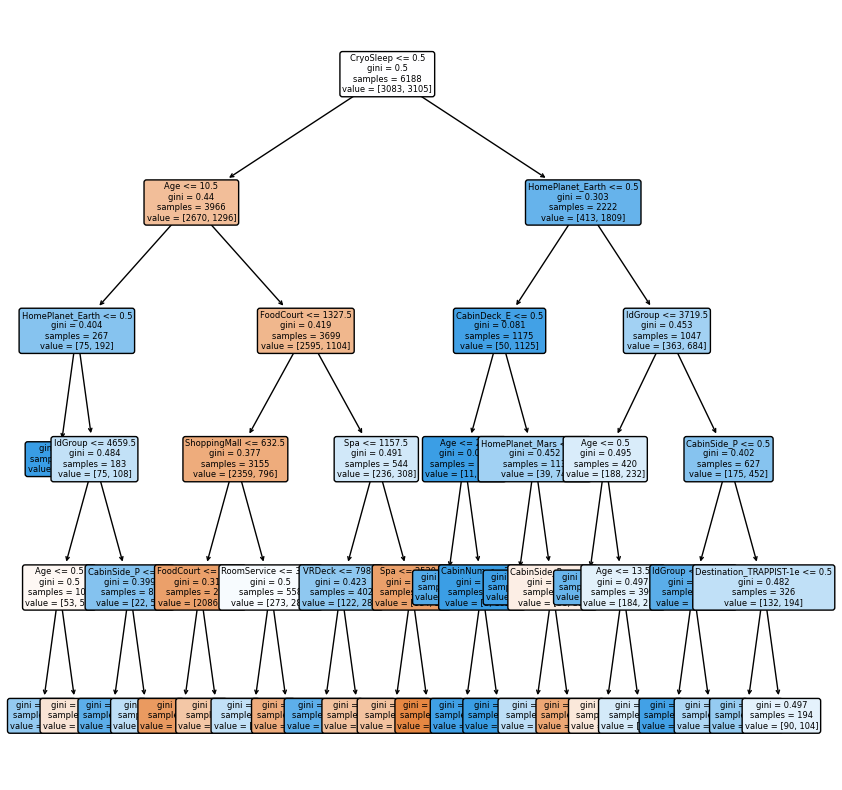

In [ ]:
ST.show_tree()

We can see that the tree has indeed avoided overfitting, as we obtain a range of colours across all of the leaf nodes. Overfitting would result in every leaf node being almost pure, and relating to essentially one data point. However, we can see a range of hues accross the leaf nodes, as well each leaf containing many samples.

Finally, we can use the accuracy function in order to see the accuracy of our tree models ability to predict the target variables.

In [ ]:
ST_no_clust_acry = np.round(ST.accuracy()*100,3)
print('The accuracy of predicted values was %', ST_no_clust_acry)

The accuracy of predicted values was % 77.907


###**Bad Tree**
We can see what a bad model would look like by creating a tree without any optimised hyperparameters.

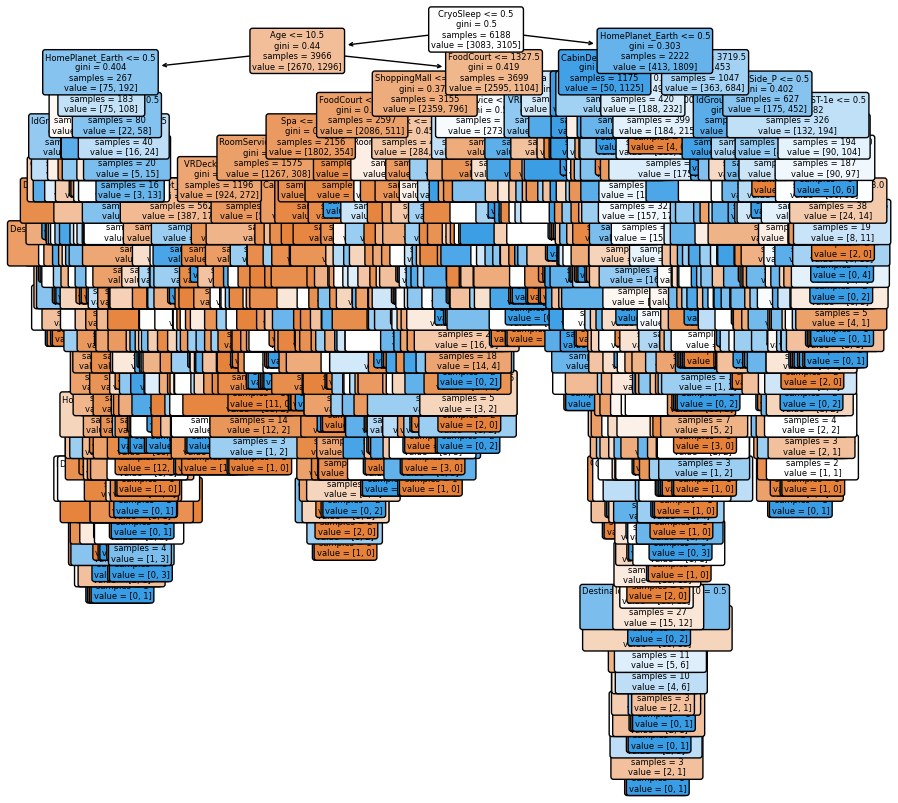

In [ ]:
ST_bad = StandardTree(data.df, 'Transported')
ST.new_DTC(min_ssplit=2, min_sleaf=1, max_d=1000)
ST.show_tree()

It is evident just from looking at this tree that the model has greatly overfit the data. We end up with an incredible number of leaf nodes, almost all of qhich conatin just one sample.

##**Random Forest**

We now instead create a random forest model using the same data on which we have performed cleaning and feature engineering. Again setting 'Transported' as the target variable.

In [ ]:
RF = RandomForest(data.df, 'Transported')

I now wish to perform a grid search on the Hyperparameters:

*   nunber of estimators
*   max depth
*   minimum samples required to split
*   minimum samples required to form a leaf

I define a dictionary called param_grid, with a number of values for each hyperparameter, and then call the grid_search function in order to perform a cross validation grid search as described above.

In [ ]:
param_grid = {
    'n_estimators': [40, 60, 80, 100],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [10, 20, 30, 40],
    'min_samples_leaf': [1, 5, 10]
}
RF.grid_search(param_grid)

Best parameters found: {'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 60}
Best score found:  0.807045571763927


After running the grid search we can now see the best possible parameters found on the grid. If these values are the border values of any the hyperparameters we can run a grid search again with an updated grid to allow for better range of options. I have done this a number of times in order to obtain the values found above.

With the best parameters automatically initialized in the class, we can now call the new_RFC function in order to update our random forest with the new best hyperparameters.

In [ ]:
RF.new_RFC()

All that's left is to now call the accuracy function in order to see the accuracy of our random forest prediciting the target values.

In [ ]:
RF_no_clust_acry = np.round(RF.accuracy()*100,3)
print('The accuracy of predicted values was %', RF_no_clust_acry)

The accuracy of predicted values was % 80.297


In order to assess the performance of the random forest model I display the confusion matrix of the test values, and the predicted values. We can see that there is an even spread of each, which implies that the model has not overfit.

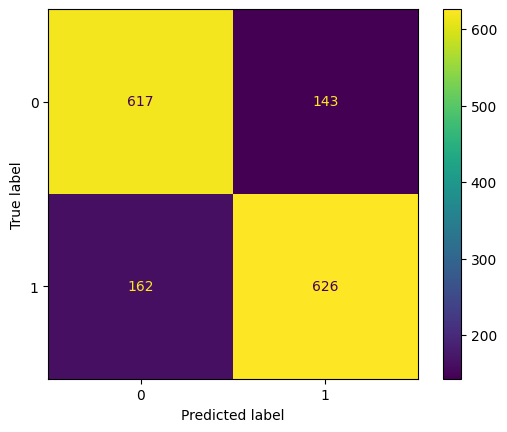

In [ ]:
cm = confusion_matrix(RF.y_test, RF.y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

##**Artificial Neural Network**

Finally, we can create an ANN class with the same data frame, and again setting 'Transported' as the target variable.

In [ ]:
ann = ANN(data.df, 'Transported')

I then get to define the model I wish to use for the ANN. For this problem I have opted to use one dense layer with 8 neurons, using the relu activation function. This model was chosen in order to avoid overfitting, given the limited data set, which is discussed further shortly.

The relu activation function causes the model to become non-linear, allowing it to pick up any possibly non-linear behaviour of the data.

It then finally hase one more dense layer with a single neuron to act as the output layer.

In [ ]:
model = [
    Dense(units=8, activation='relu', input_shape=(ann.X_train.shape[1],)),
    Dense(units=1, activation='sigmoid')
]
ann.model(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 224       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 233 (932.00 Byte)
Trainable params: 233 (932.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


I then use the optimizer function in order to initialize our optimiser with a learning rate of $\eta = 10^{-3}$, and then call the train function to train our ANN using the training and validation sets. I have opted to use binary crossentropy as the loss function as we have previously used in assignment 4. I also run the training with a batch size of 64, for 100 epochs. The batch size ensures the model is able to sample the full data set before converging by taking averages of small samples. The 100 epoch allowed the model loss to converge on the validation set, as can be seen in the figure below. This ensure we get the best possible weights without overfitting.

In [ ]:
ann.optimizer(1e-3)
ann.train('binary_crossentropy', 64, 100)

Epoch 1/100
32/32 [==============================] - 1s 11ms/step - loss: 0.6609 - val_loss: 0.6485
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6357 - val_loss: 0.6252
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6151 - val_loss: 0.6054
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 0.5970 - val_loss: 0.5879
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 0.5810 - val_loss: 0.5723
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 0.5671 - val_loss: 0.5589
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5553 - val_loss: 0.5477
Epoch 8/100
32/32 [==============================] - 0s 5ms/step - loss: 0.5462 - val_loss: 0.5378
Epoch 9/100
32/32 [==============================] - 0s 5ms/step - loss: 0.5379 - val_loss: 0.5296
Epoch 10/100
32/32 [==============================] - 0s 5ms/step - loss: 0.5311 - val_loss: 0.5223
Epoch 11

Once again we can use the accuracy function to see how accurately the ANN was able to predict the target variables.

In [ ]:
ANN_no_clust_acry = np.round(ann.accuracy()*100,3)
print('The accuracy of predicted values was %', ANN_no_clust_acry)

37/37 [==============================] - 0s 3ms/step
The accuracy of predicted values was % 75.366


In order to check for any over/underfitting, we can print the loss curve of both the training and validation sets from the models training. As we can see, both uniformly decrease, and the validation loss curve tapers off quicker towards the end as the model learns all it can from the training data. The smooth curves show that the learning rate was adequate to not overjump any important details. Similarly, the continuous decrease of both curves shows that no overfitting has occured.

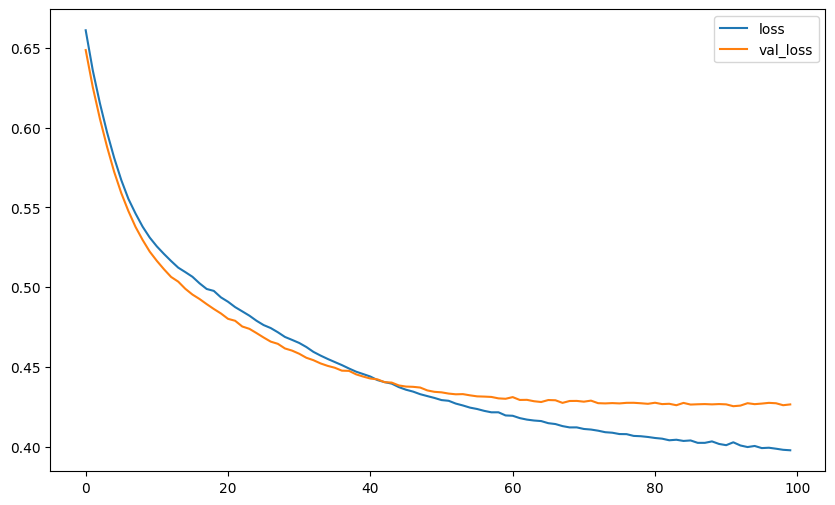

In [ ]:
ann.loss_curve()

###**Bad ANN**
I did do some testing with various models and training hyperparameters. However, I quickly found that that any additional layers in the ANN, and any significant changes to the batch size and number of epochs quickly resulted in overfitting issues.

The issue we face here is that the sample of data is quite small, and so with large numbers of neurons the model will quickly memorise all of the training data, and simply overfit. I've provided one example here, where I've simply added one extra layer with just 8 more neurons. While the accuracy increases slightly, we can see from the loss curve that the validation curve clearly increases again after reaching a minimum, clearly indicating overfitting.

In [ ]:
ann = ANN(data.df, 'Transported')
model = [
    Dense(units=8, activation='relu', input_shape=(ann.X_train.shape[1],)),
    Dense(units=8, activation='relu'),
    Dense(units=1, activation='sigmoid')
]
ann.model(model)
ann.optimizer(1e-3)
ann.train('binary_crossentropy', 64, 100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 224       
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 305 (1.19 KB)
Trainable params: 305 (1.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
32/32 [==============================] - 2s 14ms/step - loss: 0.7114 - val_loss: 0.6989
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.6889 - val_loss: 0.6832
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.6750 - val_los

37/37 [==============================] - 0s 1ms/step
The accuracy of predicted values was % 75.883


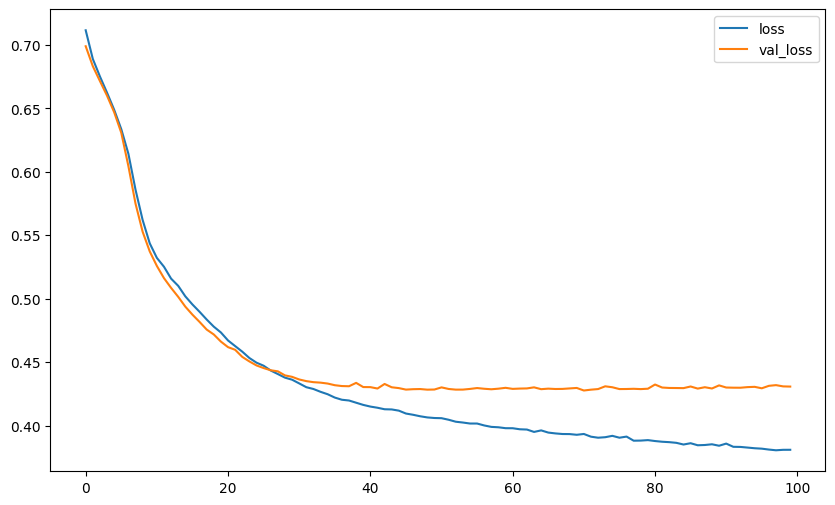

In [ ]:
print('The accuracy of predicted values was %', np.round(ann.accuracy()*100,3))
ann.loss_curve()

#**With Clustering**

I now wish to perform all of the same operations as above, however with the addition of feature engineering with clustering.

##**Cleaning and Feature Engineering**

Once again reading the data frame into a new DataPreparation class I once again call the clean function, and then FeatureEngineering with clustering set to True.
Printing the first few inputs we now see the new feature 'UMAPCluster', corresponding to the cluster label each data point belongs to.
This feature now contains some undertermined extra correlation between data points that was previously unknown.

Also, we can see that all other cleaning and feature engineering operations have been exectuted as previously, including removal of all NaNs.

In [ ]:
data2 = DataPreparation(pd.read_csv('/content/drive/MyDrive/spaceship-titanic.csv'))
data2.clean()
data2.Feature_Engineer(clustering=True)
data2.df.head()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S,UMAPCluster
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,False,...,True,False,False,False,False,False,False,True,False,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,True,...,False,False,False,False,True,False,False,False,True,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,False,...,False,False,False,False,False,False,False,False,True,2
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,False,...,False,False,False,False,False,False,False,False,True,3
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,True,...,False,False,False,False,True,False,False,False,True,1


In [ ]:
print('Number of NaNs in Age feature is:', len(data2.df.loc[data2.df.isna().Age==True]))

Number of NaNs in Age feature is: 0


We can call the plot_UMAP function in order to plot the UMAP generated by clustering, with each of the points coloured by the target variable 'Transported'.

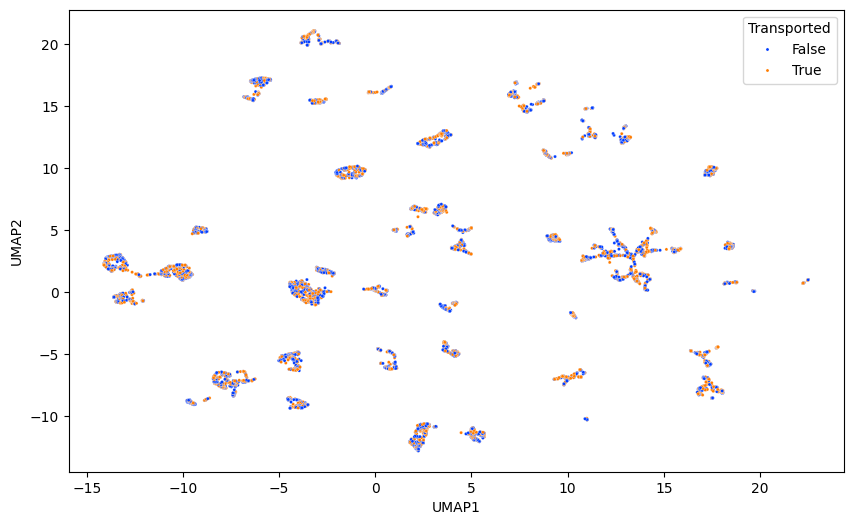

In [ ]:
data2.plot_UMAP('Transported')

We can see that there appears to be a fairly random spread of Transported values across the UMAP.

Similalry we can call the plot_UMAP_clust function to create a figure of the UMAP with points coloured by the clustering labels assigned using DBSCAN.

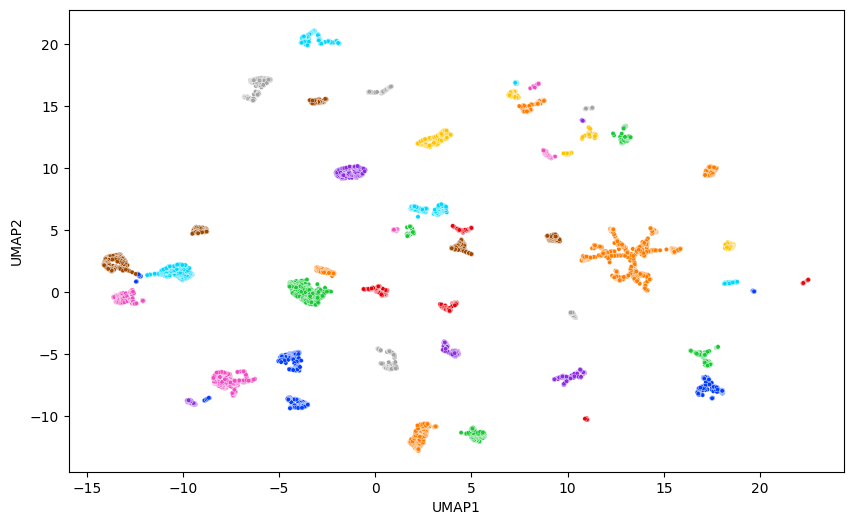

In [ ]:
data2.plot_UMAP_clust()

I have turned off the figure legend as there are too many clusters identified above. However, it is important to note that some points were indeed labeled -1, meaning they were identified to be noise.

##**Tree Model**

With our new data frame including the cluster labels, we can once again run all of the previous models to see if this new feature improves their ability to predict the target variable 'Transported'.
I first simply intialise a new StandardTree class with the target feature 'Transported'.

In [ ]:
ST_clust = StandardTree(data2.df, 'Transported')

Then create a new decision tree clasifier model with the same hyperparameters as before.

In [ ]:
ST_clust.new_DTC(min_ssplit=50, min_sleaf=10, max_d=5)

Looking at the new DTC tree we can see that the leaf nodes do appear more pure than previously, however we do still see a gradient of colours indicating no overfitting.

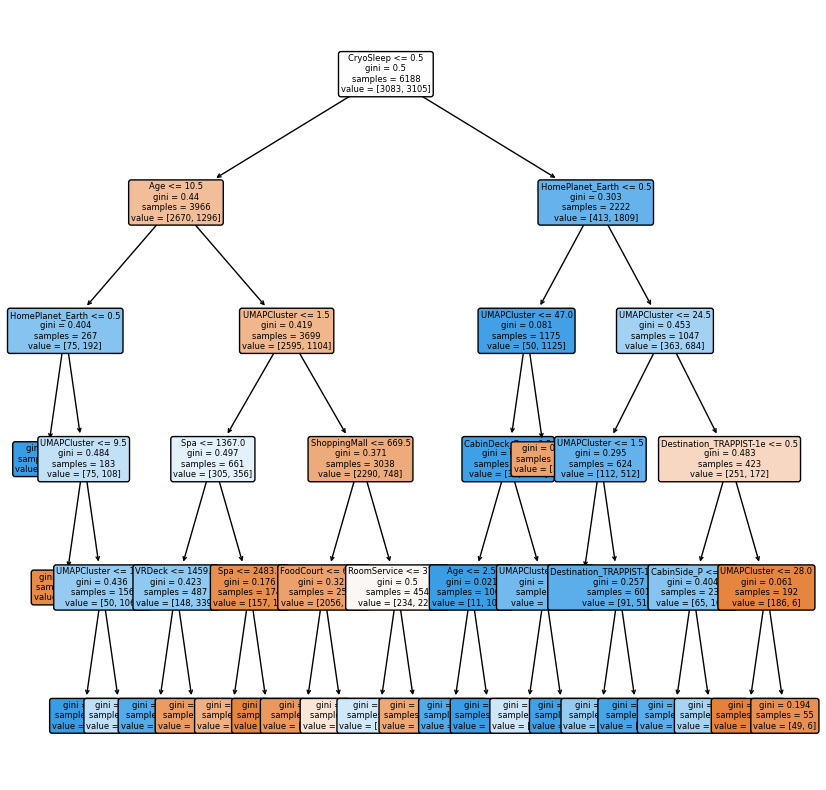

In [ ]:
ST_clust.show_tree()

Once again we call accuracy to asses the models ability to predict the target variable, and we can clearly see that the accuracy has indeed improved with clustering.

In [ ]:
ST_clust_acry = np.round(ST_clust.accuracy()*100,3)
print('The accuracy of predicted values was %', ST_clust_acry)

The accuracy of predicted values was % 81.912


##**Random Forest**

I now create a new RandomForest class with 'Transported' as the target variable.

In [ ]:
RF_clust = RandomForest(data2.df, 'Transported')

I now once again run a hyperparamater optimization with the same dictionary as before.

In [ ]:
param_grid = {
    'n_estimators': [40, 60, 80, 100],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [10, 20, 30, 40],
    'min_samples_leaf': [1, 5, 10]
}
RF_clust.grid_search(param_grid)

Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 60}
Best score found:  0.8783123087346077


As with the decision tree, we can see that the accuracy of our random forest has once again gretly improved with clustering.

In [ ]:
RF_clust.new_RFC()
RF_clust_acry = np.round(RF_clust.accuracy()*100,3)
print('The accuracy of predicted values was %', RF_clust_acry)

The accuracy of predicted values was % 88.501


Again plotting the confusion matrix of the test values against the predicted values we can see an even spread, again indicating no overfit.

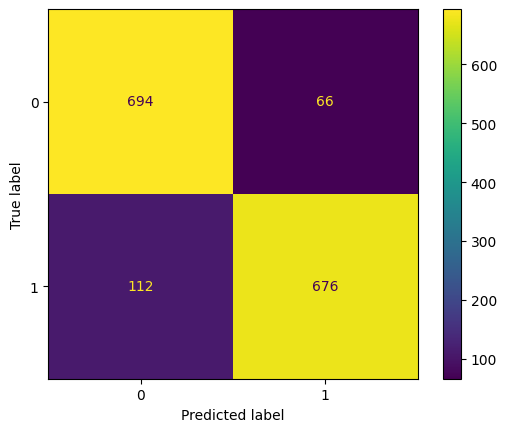

In [ ]:
cm2 = confusion_matrix(RF_clust.y_test, RF_clust.y_pred)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot()

##**Artificial Nearual Network**

Finally, for the last step a create a new ANN class with 'Transported' as the target variable.

In [ ]:
ann_clust = ANN(data2.df, 'Transported')

Using the same model as before I create a new artificial neural network to learn from the data.

In [ ]:
model = [
    Dense(units=8, activation='relu', input_shape=(ann_clust.X_train.shape[1],)),
    Dense(units=1, activation='sigmoid')
]
ann_clust.model(model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8)                 232       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 241 (964.00 Byte)
Trainable params: 241 (964.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


I can then create a new optimizer with the same learning rate of $\eta=10^{-3}$, and train this on the training and validation data with the same hyperparameters as before.

In [ ]:
ann_clust.optimizer(1e-3)
ann_clust.train('binary_crossentropy', 64, 100)

Epoch 1/100
32/32 [==============================] - 1s 10ms/step - loss: 0.6797 - val_loss: 0.6789
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6673 - val_loss: 0.6667
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6555 - val_loss: 0.6543
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6434 - val_loss: 0.6401
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6293 - val_loss: 0.6253
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6156 - val_loss: 0.6106
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6022 - val_loss: 0.5968
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5889 - val_loss: 0.5839
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5773 - val_loss: 0.5721
Epoch 10/100
32/32 [==============================] - 0s 5ms/step - loss: 0.5670 - val_loss: 0.5618
Epoch 11

With the ANN trained, I call accuracy for the last time.

In [ ]:
ANN_clust_acry = np.round(ann_clust.accuracy()*100,3)
print('The accuracy of predicted values was %', ANN_clust_acry)

37/37 [==============================] - 0s 2ms/step
The accuracy of predicted values was % 78.467


While the ANN has made imporvements with clustering, interestingly it appears to have had less of an impact than it did on the previous models.

We can once again plot the loss curve in order to check for any possible issues with the ANN.

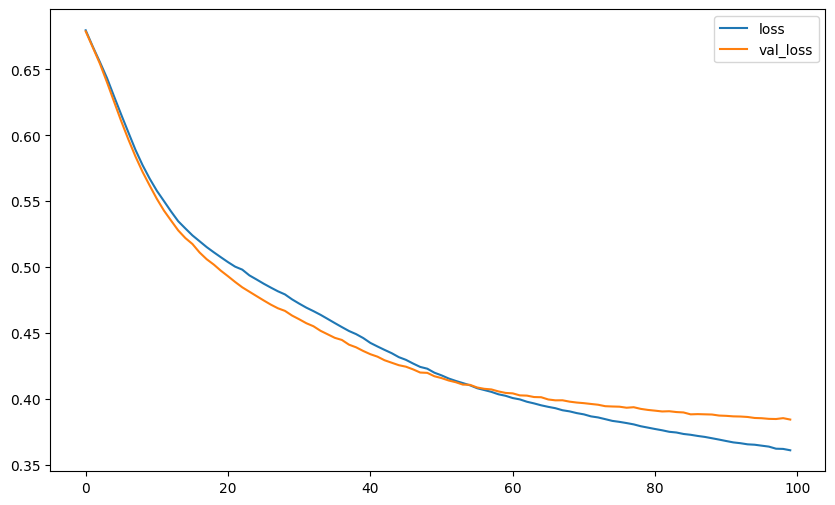

In [ ]:
ann_clust.loss_curve()

We can clearly see above that as before, both training and validations curves decrease uniforly over their training. This means that the learning rate is sufficient to alter the weights accurately, and we don't see any overfitting.

#**Model Comparison**
From all of the accuracy scores obtained from each of the models, both with and without clustering techniques, we can assess which has produced the best results.

In [ ]:
print('Decision Tree Reults:')
print('Decision Tree without clustering: %', ST_no_clust_acry)
print('Decision Tree with clustering: %', ST_clust_acry)
print('\n')
print('Random Forest Reults:')
print('Random Forest without clustering: %', RF_no_clust_acry)
print('Random Forest with clustering: %', RF_clust_acry)
print('\n')
print('Artificial Neural Net Reults:')
print('Artificial Neural Net without clustering: %', ANN_no_clust_acry)
print('Artificial Neural Net with clustering: %', ANN_clust_acry)

Decision Tree Reults:
Decision Tree without clustering: % 77.907
Decision Tree with clustering: % 81.912


Random Forest Reults:
Random Forest without clustering: % 80.297
Random Forest with clustering: % 88.501


Artificial Neural Net Reults:
Artificial Neural Net without clustering: % 75.366
Artificial Neural Net with clustering: % 78.467


From all of the results we can now finally reach two conclusions:

*   The Random Forest model produced the best results. Having the highest accuracy when predicting the target variable both with, and without clustering techniques.
*   Feature Engineering with clustering techniques was an important step in this project, as it yielded better results from every model.

#**Function Help Section**

In [ ]:
help(DataPreparation)

Help on class DataPreparation in module __main__:

class DataPreparation(builtins.object)
 |  DataPreparation(data_frame)
 |  
 |  This class is used to clean the data, and perform Feature Engineering
 |  
 |  Methods defined here:
 |  
 |  Feature_Engineer(self, clustering)
 |      Performs Feature Engineering both with and without clustering.
 |      
 |      Args:
 |          clustering (bool): If False, will perfome Feature Engineering without 
 |          clustering. If True, will perfome Feature Engineering with clustering.
 |      
 |      Returns:
 |          None
 |  
 |  __init__(self, data_frame)
 |      Initialises the data frame.
 |      
 |      Args:
 |          data_frame (pandas.DataFrame): The data frame being used for 
 |          Machine Learning
 |      
 |      Returns:
 |          None
 |  
 |  clean(self)
 |      Cleans the data.
 |      
 |      Args:
 |          None
 |      
 |      Returns:
 |          None
 |  
 |  plot_UMAP(self, target_var)
 |      Genera

In [ ]:
help(StandardTree)

Help on class StandardTree in module __main__:

class StandardTree(builtins.object)
 |  StandardTree(data_frame, target_var)
 |  
 |  This Class is used to generate a standard Decision Tree Classifier
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data_frame, target_var)
 |      Splits the data frame into learning features 'X' and the target variable 'y'
 |      and fits a standard Decision Tree Classifier to the training sets.
 |      
 |      Args:
 |          data_frame (pandas.DataFrame): data frame to be used for machine learning
 |          target_var (str): String defining the target variable of the data frame
 |      
 |      Returns:
 |          None
 |  
 |  accuracy(self)
 |      Returns the accuracy of the tree prediciting the target variable.
 |      
 |      Args:
 |          None
 |      
 |      Returns:
 |          accuracy_score (float): The fraction of correctly classified samples
 |  
 |  new_DTC(self, min_ssplit, min_sleaf, max_d)
 |      Creates a new deci

In [ ]:
help(RandomForest)

Help on class RandomForest in module __main__:

class RandomForest(builtins.object)
 |  RandomForest(data_frame, target_var)
 |  
 |  This Class is used to generate a standard Decision Tree Classifier
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data_frame, target_var)
 |      Splits the data frame into learning features 'X' and the target variable 'y'
 |      and creates a Randome Rorrest Classifier.
 |      
 |      Args:
 |          data_frame (pandas.DataFrame): data frame to be used for machine learning
 |          target_var (str): String defining the target variable of the data frame
 |      
 |      Returns:
 |          None
 |  
 |  accuracy(self)
 |      Returns the accuracy of the RFC prediciting the target variable.
 |      
 |      Args:
 |          None
 |      
 |      Returns:
 |          accuracy_score (float): The fraction of correctly classified samples
 |  
 |  grid_search(self, param_grid)
 |      Takes a grid of Hyperparameters and performs a grid search

In [ ]:
help(ANN)

Help on class ANN in module __main__:

class ANN(builtins.object)
 |  ANN(data_frame, target_var)
 |  
 |  This class is used to generate an Atrificial Neural Network
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data_frame, target_var)
 |      Splits the data frame into learning features 'X' and the target variable 'y'
 |      creates scaled and balanced arrays of the training, validation and test 
 |      data sets.
 |      
 |      Args:
 |          data_frame (pandas.DataFrame): data frame to be used for machine learning
 |          target_var (str): String defining the target variable of the data frame
 |      
 |      Returns:
 |          None
 |  
 |  accuracy(self)
 |      Returns the accuracy of the ANN prediciting the target variable.
 |      
 |      Args:
 |          None
 |      
 |      Returns:
 |          accuracy_score (float): The fraction of correctly classified samples
 |  
 |  loss_curve(self)
 |      Generates a figure displaying the loss curve for the va